In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузка данных
iris = load_iris()
X = iris.data  # 4 параметра: sepal length, sepal width, petal length, petal width
y = iris.target  # реальные классы
feature_names = iris.feature_names
target_names = iris.target_names

print("Информация о наборе данных Iris:")
print(f"Размерность данных: {X.shape}")
print(f"Параметры: {feature_names}")
print(f"Виды: {target_names}")

Информация о наборе данных Iris:
Размерность данных: (150, 4)
Параметры: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Виды: ['setosa' 'versicolor' 'virginica']


Лучший ARI достигнут: 0.6451


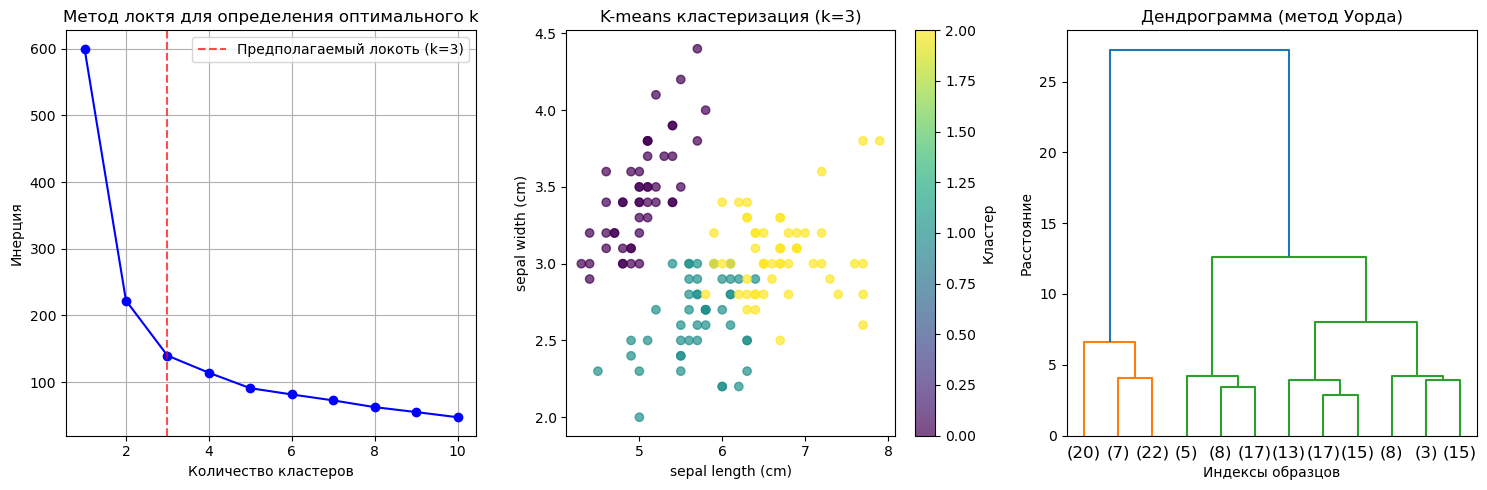

In [44]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Метод локтя для определения оптимального количества кластеров
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, init='k-means++')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# График метода локтя
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения оптимального k')
plt.grid(True)

# Отметим предполагаемый "локоть"
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Предполагаемый локоть (k=3)')
plt.legend()

# 2. Кластеризация K-means с k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10, init='k-means++')

best_ari = -1
best_kmeans = None
best_kmeans_labels = None
for random_state in [42, 0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    kmeans_temp = KMeans(n_clusters=3, init='k-means++', random_state=random_state, n_init=1)
    temp_labels = kmeans_temp.fit_predict(X_scaled)
    temp_ari = adjusted_rand_score(y, temp_labels)
    
    if temp_ari > best_ari:
        best_ari = temp_ari
        best_kmeans = kmeans_temp
        best_kmeans_labels = temp_labels

print(f"Лучший ARI достигнут: {best_ari:.4f}")

kmeans = best_kmeans
kmeans_labels = best_kmeans_labels

from scipy.stats import mode

def match_cluster_labels(true_labels, cluster_labels):
    matched_labels = np.zeros_like(cluster_labels)
    
    for cluster in np.unique(cluster_labels):
        mask = (cluster_labels == cluster)
        true_class = mode(true_labels[mask])[0]
        matched_labels[mask] = true_class
        
    return matched_labels

# Применяем сопоставление меток
kmeans_labels = match_cluster_labels(y, kmeans_labels)

# Визуализация результатов K-means
plt.subplot(1, 3, 2)
scatter = plt.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('K-means кластеризация (k=3)')
plt.colorbar(scatter, label='Кластер')

# 3. Иерархическая кластеризация методом Уорда
plt.subplot(1, 3, 3)
Z = linkage(X_scaled, method='ward')
dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True)
plt.title('Дендрограмма (метод Уорда)')
plt.xlabel('Индексы образцов')
plt.ylabel('Расстояние')

plt.tight_layout()
plt.show()

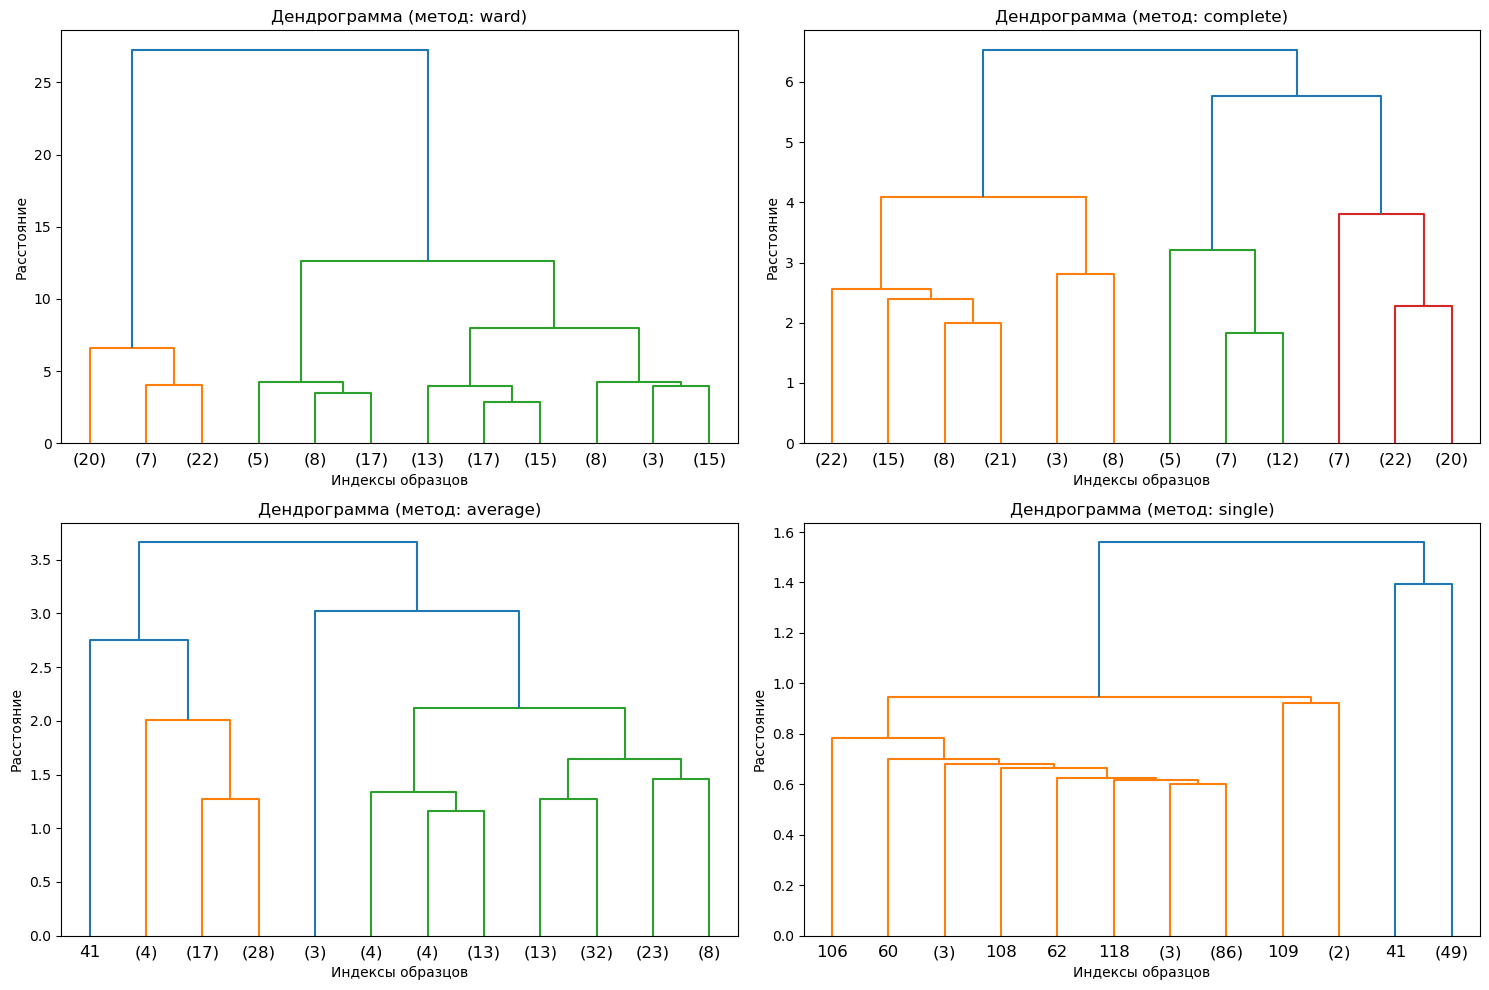

In [45]:
# Иерархическая кластеризация с разными параметрами
methods = ['ward', 'complete', 'average', 'single']
plt.figure(figsize=(15, 10))

for i, method in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    Z = linkage(X_scaled, method=method)
    dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True)
    plt.title(f'Дендрограмма (метод: {method})')
    plt.xlabel('Индексы образцов')
    plt.ylabel('Расстояние')

plt.tight_layout()
plt.show()

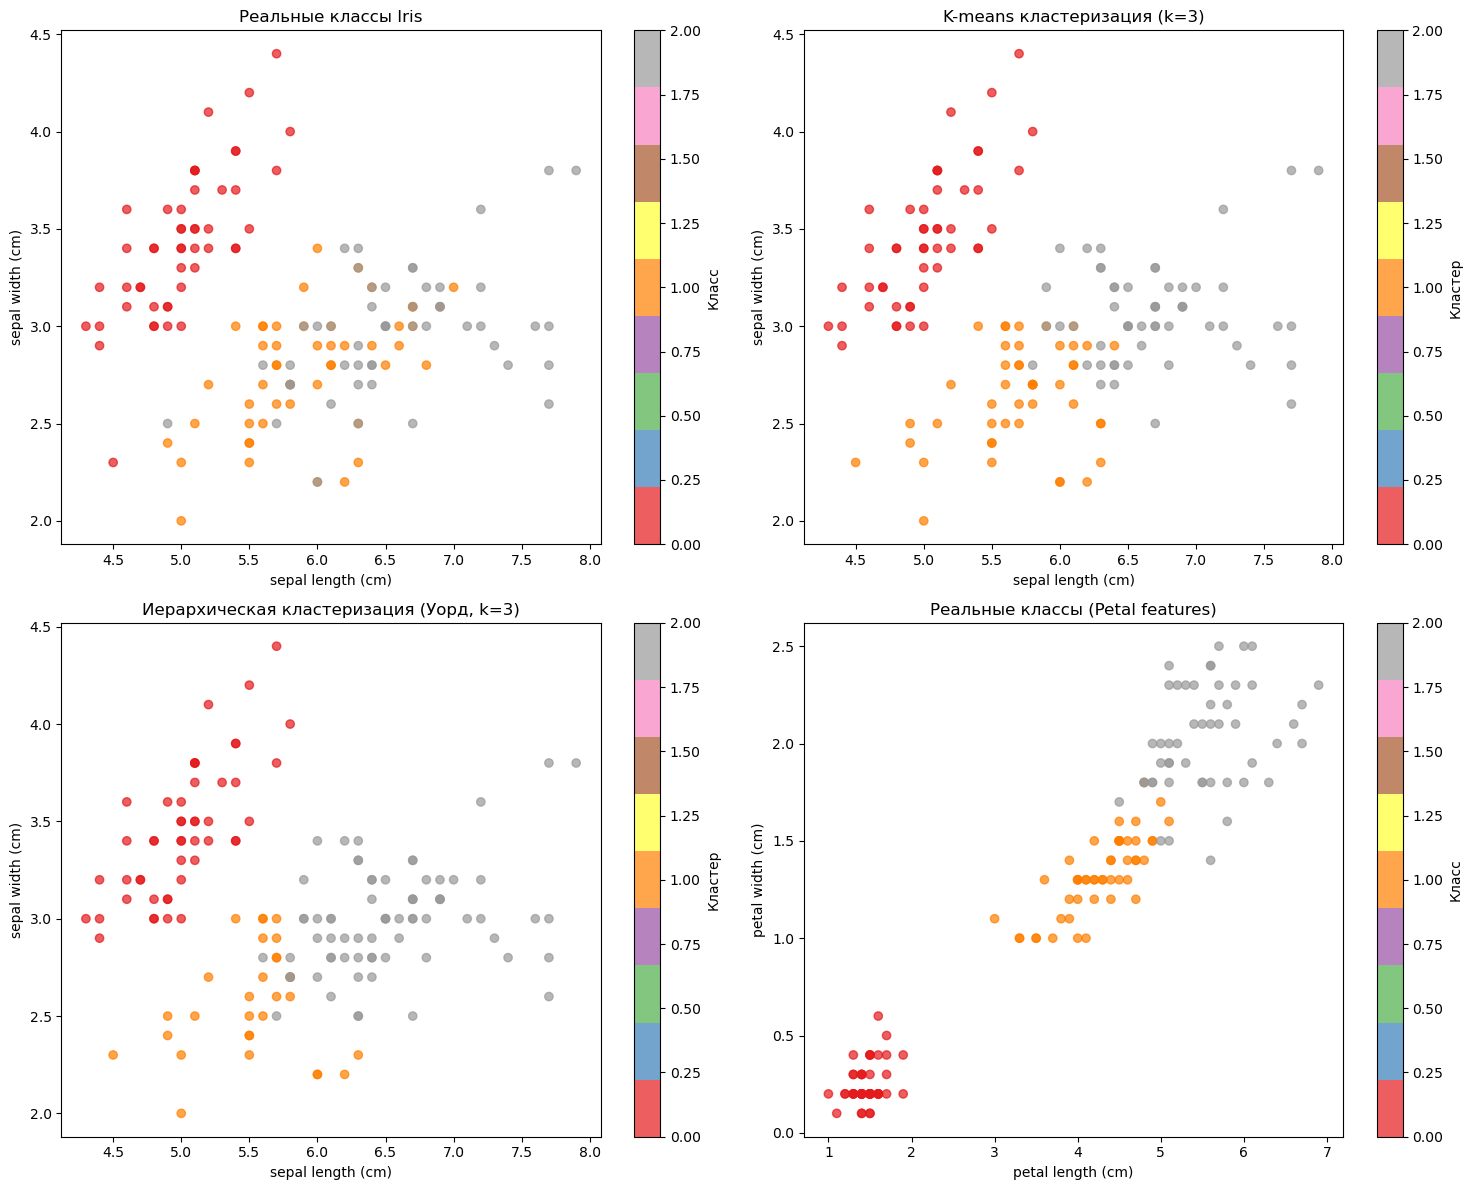

In [46]:
# Кластеризация методом Уорда с 3 кластерами
Z_ward = linkage(X_scaled, method='ward')
ward_labels = fcluster(Z_ward, t=3, criterion='maxclust') - 1  # Приводим к 0-based индексации

# Сравнение результатов кластеризации с реальными классами
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Реальные классы
scatter1 = axes[0, 0].scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', alpha=0.7)
axes[0, 0].set_xlabel(feature_names[0])
axes[0, 0].set_ylabel(feature_names[1])
axes[0, 0].set_title('Реальные классы Iris')
plt.colorbar(scatter1, ax=axes[0, 0], label='Класс')

# K-means кластеризация
scatter2 = axes[0, 1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='Set1', alpha=0.7)
axes[0, 1].set_xlabel(feature_names[0])
axes[0, 1].set_ylabel(feature_names[1])
axes[0, 1].set_title('K-means кластеризация (k=3)')
plt.colorbar(scatter2, ax=axes[0, 1], label='Кластер')

# Иерархическая кластеризация (Уорд)
scatter3 = axes[1, 0].scatter(X[:, 0], X[:, 1], c=ward_labels, cmap='Set1', alpha=0.7)
axes[1, 0].set_xlabel(feature_names[0])
axes[1, 0].set_ylabel(feature_names[1])
axes[1, 0].set_title('Иерархическая кластеризация (Уорд, k=3)')
plt.colorbar(scatter3, ax=axes[1, 0], label='Кластер')

# Сравнение по другим параметрам (petal)
scatter4 = axes[1, 1].scatter(X[:, 2], X[:, 3], c=y, cmap='Set1', alpha=0.7)
axes[1, 1].set_xlabel(feature_names[2])
axes[1, 1].set_ylabel(feature_names[3])
axes[1, 1].set_title('Реальные классы (Petal features)')
plt.colorbar(scatter4, ax=axes[1, 1], label='Класс')

plt.tight_layout()
plt.show()

СРАВНЕНИЕ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ
Метод                          Silhouette Score     Adjusted Rand Index 
----------------------------------------------------------------------
K-means (k=3)                  0.4599               0.6201              
Иерархическая (Уорд, k=3)      0.4467               0.6153              


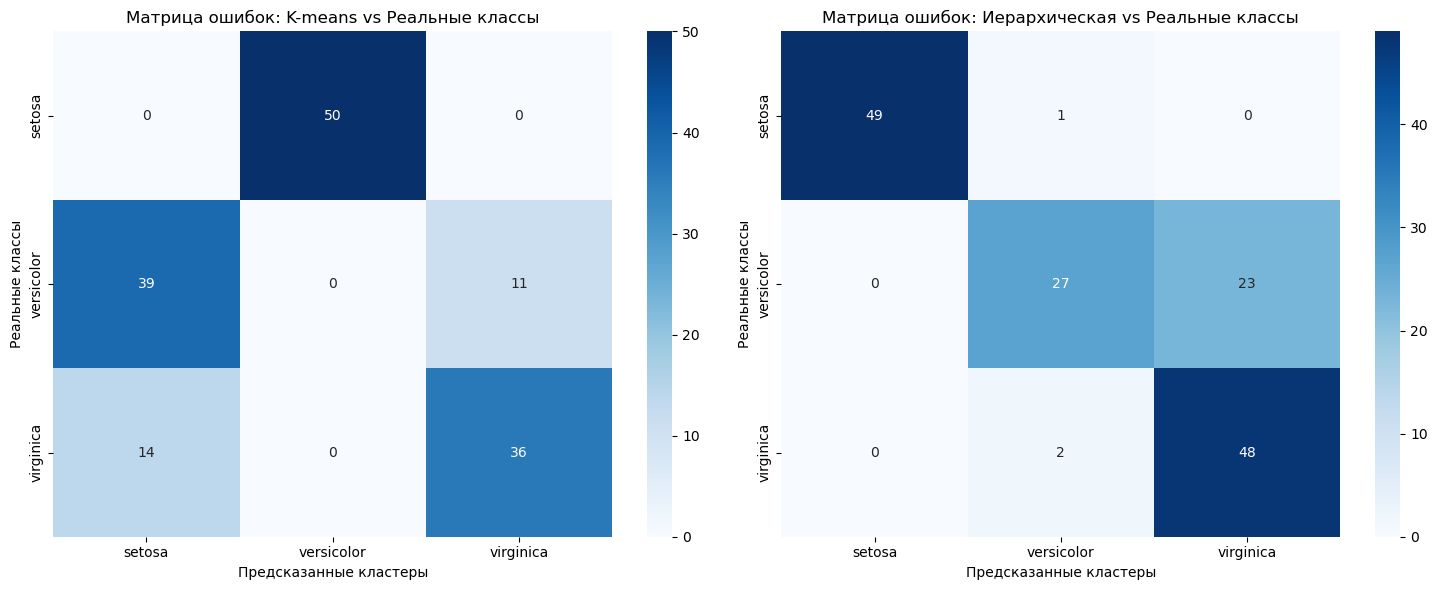

In [31]:
# Количественная оценка качества кластеризации
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Метрики для K-means
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)

# Метрики для иерархической кластеризации
ward_silhouette = silhouette_score(X_scaled, ward_labels)
ward_ari = adjusted_rand_score(y, ward_labels)

print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ")
print("=" * 50)
print(f"{'Метод':<30} {'Silhouette Score':<20} {'Adjusted Rand Index':<20}")
print("-" * 70)
print(f"{'K-means (k=3)':<30} {kmeans_silhouette:<20.4f} {kmeans_ari:<20.4f}")
print(f"{'Иерархическая (Уорд, k=3)':<30} {ward_silhouette:<20.4f} {ward_ari:<20.4f}")

# Матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# K-means
cm_kmeans = confusion_matrix(y, kmeans_labels)
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title('Матрица ошибок: K-means vs Реальные классы')
axes[0].set_xlabel('Предсказанные кластеры')
axes[0].set_ylabel('Реальные классы')

# Иерархическая
cm_ward = confusion_matrix(y, ward_labels)
sns.heatmap(cm_ward, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title('Матрица ошибок: Иерархическая vs Реальные классы')
axes[1].set_xlabel('Предсказанные кластеры')
axes[1].set_ylabel('Реальные классы')

plt.tight_layout()
plt.show()

ВЛИЯНИЕ ПАРАМЕТРОВ K-MEANS НА РЕЗУЛЬТАТ
n_init=1   | random_state=0    | Inertia: 139.8205
n_init=1   | random_state=42   | Inertia: 191.0247
n_init=1   | random_state=100  | Inertia: 140.9015
n_init=1   | random_state=999  | Inertia: 140.0328
n_init=5   | random_state=0    | Inertia: 139.8205
n_init=5   | random_state=42   | Inertia: 139.8205
n_init=5   | random_state=100  | Inertia: 140.0820
n_init=5   | random_state=999  | Inertia: 140.0328
n_init=10  | random_state=0    | Inertia: 139.8205
n_init=10  | random_state=42   | Inertia: 139.8205
n_init=10  | random_state=100  | Inertia: 140.0328
n_init=10  | random_state=999  | Inertia: 140.0328
n_init=20  | random_state=0    | Inertia: 139.8205
n_init=20  | random_state=42   | Inertia: 139.8205
n_init=20  | random_state=100  | Inertia: 139.8205
n_init=20  | random_state=999  | Inertia: 139.8205
n_init=50  | random_state=0    | Inertia: 139.8205
n_init=50  | random_state=42   | Inertia: 139.8205
n_init=50  | random_state=100  | Inertia: 

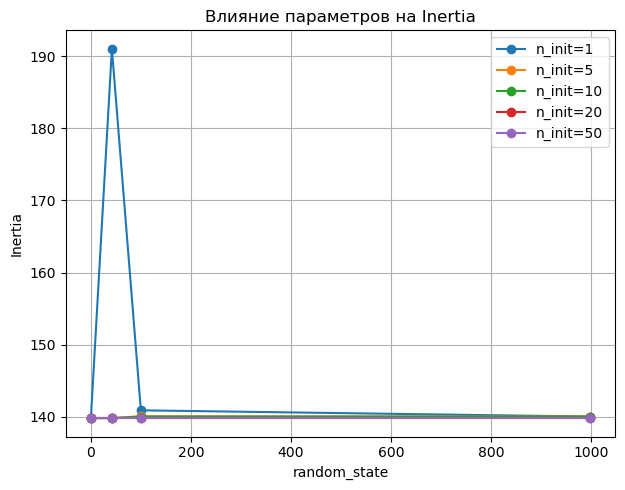

In [22]:
# Анализ влияния параметров K-means
n_init_values = [1, 5, 10, 20, 50]
random_states = [0, 42, 100, 999]

results = []

print("ВЛИЯНИЕ ПАРАМЕТРОВ K-MEANS НА РЕЗУЛЬТАТ")
print("=" * 60)

for n_init in n_init_values:
    for random_state in random_states:
        kmeans_test = KMeans(n_clusters=3, n_init=n_init, random_state=random_state)
        labels_test = kmeans_test.fit_predict(X_scaled)
        inertia_test = kmeans_test.inertia_
        ari_test = adjusted_rand_score(y, labels_test)

        results.append({
            'n_init': n_init,
            'random_state': random_state,
            'inertia': inertia_test,
        })

        print(f"n_init={n_init:<3} | random_state={random_state:<4} | "
              f"Inertia: {inertia_test:.4f}")

# Визуализация влияния параметров
results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for n_init in n_init_values:
    subset = results_df[results_df['n_init'] == n_init]
    plt.plot(subset['random_state'], subset['inertia'], 'o-', label=f'n_init={n_init}')
plt.xlabel('random_state')
plt.ylabel('Inertia')
plt.title('Влияние параметров на Inertia')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
# Детальный анализ кластеров
def analyze_clusters(labels, method_name):
    print(f"\n{method_name} - АНАЛИЗ КЛАСТЕРОВ")
    print("-" * 40)

    cluster_df = pd.DataFrame(X, columns=feature_names)
    cluster_df['Cluster'] = labels
    cluster_df['True_Class'] = y
    cluster_df['True_Class_Name'] = [target_names[i] for i in y]

    # Статистика по кластерам
    cluster_stats = cluster_df.groupby('Cluster').agg({
        'True_Class': lambda x: pd.Series.mode(x)[0],
        'True_Class_Name': lambda x: pd.Series.mode(x)[0],
        feature_names[0]: ['mean', 'std'],
        feature_names[1]: ['mean', 'std'],
        feature_names[2]: ['mean', 'std'],
        feature_names[3]: ['mean', 'std']
    }).round(3)

    print("Статистика по кластерам:")
    print(cluster_stats)

    # Соответствие кластеров реальным классам
    print(f"\nСоответствие кластеров реальным классам:")
    contingency_table = pd.crosstab(cluster_df['Cluster'], cluster_df['True_Class_Name'])
    print(contingency_table)

    return cluster_df

# Анализ для обоих методов
kmeans_df = analyze_clusters(kmeans_labels, "K-MEANS")
ward_df = analyze_clusters(ward_labels, "ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ")


K-MEANS - АНАЛИЗ КЛАСТЕРОВ
----------------------------------------
Статистика по кластерам:
        True_Class True_Class_Name sepal length (cm)        sepal width (cm)  \
          <lambda>        <lambda>              mean    std             mean   
Cluster                                                                        
0                1      versicolor             5.802  0.405            2.674   
1                0          setosa             5.006  0.352            3.428   
2                2       virginica             6.781  0.491            3.096   

               petal length (cm)        petal width (cm)         
           std              mean    std             mean    std  
Cluster                                                          
0        0.254             4.370  0.560            1.413  0.311  
1        0.379             1.462  0.174            0.246  0.105  
2        0.262             5.511  0.638            1.972  0.331  

Соответствие кластеров реаль